# Model Training of Base Model
Model training here contains:
- Dataset only sourced google speech commands dataset
- AudioDataGenerator to perform downsampling 
- Simple CNN architecture    

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow import keras
import seaborn as sns 
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

#from local package 
from modules.data_preprocessing import AudioDataGenerator


## Constants

In [ ]:
TARGET_WORD='marvin'
BACKGROUND_WORD="background"
SEED= 423453
SPEECH_DATA='audio_data'
BATCH_SIZE=32
VAL_BATCH_SIZE=8
IMG_WIDTH=43
IMG_HEIGHT=99
NOISE_FLOOR=0.1

In [3]:
def list_subfolders(folder_path):
    subfolders = [f.path[len(folder_path)+1:] for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

words = list_subfolders(SPEECH_DATA)
classes=[word for word in words if "_" not in word]

#extacting split dataset filenames
import pickle
with open('data/dict_split.pkl', 'rb') as handle:
    split_data = pickle.load(handle)


#Initializing custom data generator that augments the dataset.
datagen_train=AudioDataGenerator(filenames=split_data['train'],
                                 classes=classes,
                                 data_folder=SPEECH_DATA,
                                 noise_floor=NOISE_FLOOR,
                                 target=TARGET_WORD,
                                 batch_size=BATCH_SIZE,
                                 training=True,
                                 augment=False,
                                 dynamic_sampling=False)

datagen_val=AudioDataGenerator(filenames=split_data['val'],
                               classes=classes,
                               data_folder=SPEECH_DATA,
                               noise_floor=NOISE_FLOOR,
                               target=TARGET_WORD,
                               batch_size=VAL_BATCH_SIZE,
                               training=False,
                               augment=False)

## Model Achitecture

In [4]:
def build_model(kernal_reg=0.0001):
    tf.keras.backend.clear_session()
    keras.utils.set_random_seed(SEED)
 
    model = Sequential([
        Conv2D(4, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer1',
               input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)),
        MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
        Conv2D(8, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer2'),
        MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
        Conv2D(16, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer3'),
        MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
        Flatten(),
        Dropout(0.2),
        Dense(
            40,
            activation='relu',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='hidden_layer1'
        ),
        Dense(
            1, 
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='output'
        )
    ])
    return model


In [5]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 8)         296       
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 24, 10, 8)        0         
                                                                 
 conv_layer3 (Conv2D)        (None, 24, 10, 16)        1168      
                                                                 
 max_pooling3 (MaxPooling2D)  (None, 12, 5, 16)        0         
                                                                 
 flatten (Flatten)           (None, 960)               0

## Training 

In [6]:
epochs=60
patience=10
lr=1e-3


model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",save_weights_only=True,save_best_only=True)

In [7]:
history=model.fit(x=datagen_train,
                  validation_data=datagen_val, 
                  epochs=epochs,
                  callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/60
58/58 [==============================] - 18s 285ms/step - loss: 0.5711 - accuracy: 0.7236 - val_loss: 0.5250 - val_accuracy: 0.7664
Epoch 2/60
58/58 [==============================] - 14s 238ms/step - loss: 0.4153 - accuracy: 0.8265 - val_loss: 0.4193 - val_accuracy: 0.8355
Epoch 3/60
58/58 [==============================] - 14s 237ms/step - loss: 0.3690 - accuracy: 0.8524 - val_loss: 0.4197 - val_accuracy: 0.8322
Epoch 4/60
58/58 [==============================] - 14s 247ms/step - loss: 0.3166 - accuracy: 0.8728 - val_loss: 0.3623 - val_accuracy: 0.8618
Epoch 5/60
58/58 [==============================] - 14s 240ms/step - loss: 0.2796 - accuracy: 0.8922 - val_loss: 0.3706 - val_accuracy: 0.8651
Epoch 6/60
58/58 [==============================] - 14s 244ms/step - loss: 0.2521 - accuracy: 0.9084 - val_loss: 0.3122 - val_accuracy: 0.8849
Epoch 7/60
58/58 [==============================] - 15s 255ms/step - loss: 0.2287 - accuracy: 0.9165 - val_loss: 0.2968 - val_accuracy: 0.8783

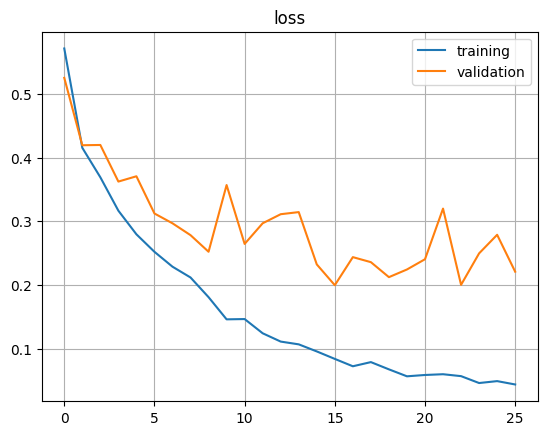

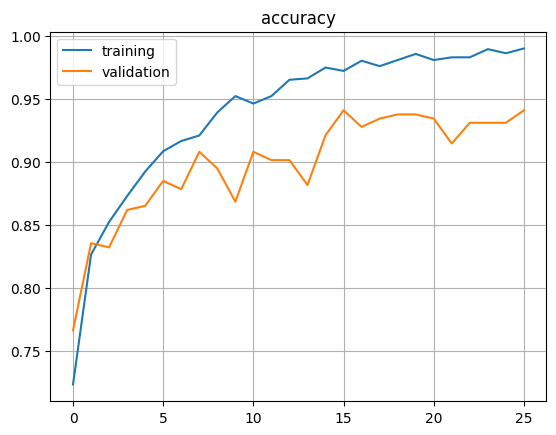

In [8]:
metrics=history.history
plt.plot(metrics['loss'],label='training')
plt.plot(metrics['val_loss'],label='validation')
plt.legend()
plt.title('loss')
plt.grid()
plt.show()

plt.plot(metrics['accuracy'],label='training')
plt.plot(metrics['val_accuracy'],label='validation')
plt.legend()
plt.title('accuracy')
plt.grid()
plt.show()

## Saving Model Weights and training history

In [19]:
model.save('models/model_training5.keras')

# create a binary pickle file 
f = open("data/model8history.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(history.history,f)

# close file
f.close()